In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("/Users/sidravi/Documents/IDInsight/IndusAction/ia_power")

In [3]:
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.nodes.imputation import *
import src.utils as utl
import arviz as az

import seaborn as sns

In [4]:
%config Completer.use_jedi = False

In [5]:
import multiprocessing
multiprocessing.set_start_method("fork")

## Generate some data

$$ 
Y = Z W' + \epsilon \\
\epsilon \sim N(0, 0.2)
$$

In [6]:
W = np.array([[100, 20],
               [15, 2],
               [2, 1]]) # n_demographics x n_features

In [7]:
Z = np.array([[1, 5],
               [3, 2],
               [2, 2],
               [3, 1],
               [4, 2],
               [2, 3],
               [1, 1],
               [4, 4],
               [0, 1]]) # n_beneficiaries x n_features

In [8]:
demo_value = np.random.normal(Z @ W.T, 0.2)

In [9]:
df = pd.DataFrame(demo_value, 
                  index = pd.Series([f'b_{x}' for x in np.arange(demo_value.shape[0])], name='beneficiaries'),
                  columns=['c0', 'c1', 'c2'])
#df = df.melt(ignore_index=False, var_name = 'demog', value_name = 'demo_value').reset_index()
#df.index.name = "hello"
#df.columns.to_list()
df

,c0,c1,c2
beneficiaries,,,
b_0,199.880110,24.816602,7.316327
b_1,339.992869,49.022033,7.983792
b_2,240.108822,33.832292,5.989315
b_3,319.928045,46.796998,7.063869
b_4,439.902101,64.035031,9.863494
b_5,260.186264,35.808079,6.897217
b_6,120.033886,17.100802,2.769395
b_7,479.816152,68.249001,11.817535
b_8,20.041142,2.317522,1.694963


## Set some to null
We'll try to impute these

In [10]:
index_to_null = [('b_0', 'c0'), ('b_1', 'c0'), ('b_2', 'c2'), ('b_3', 'c2'), ('b_6', 'c1')]
df_nulled = df.copy()
for row, col in index_to_null:
    df_nulled.loc[row, col] = np.nan

## Run stan model

In [11]:
stan_code = utl.load_params_file('stan_code_mc')
mc_params = utl.load_params_file('bayesian_mc_params')

In [13]:
bmc = BayesianMatrixCompletion(stan_code, False, True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3391bc7a0790d8690bad0b444d48369b NOW.


In [15]:
bmc.fit(df_nulled, 2)

In [17]:
bmc.fitted

True

In [22]:
bmc

BayesianMatrixCompletion(latent_features: 2, fitted: True)

In [18]:
samples = bmc.sample(2200, mc_params)

In [19]:
samples[1]

,c0,c1,c2
b_0,294.592279,36.192421,7.594721
b_1,279.151508,37.160600,7.769785
b_2,243.673396,31.016587,6.498018
b_3,260.522787,50.553507,10.426387
b_4,500.550021,57.896913,12.184548
b_5,193.424409,33.875505,7.009353
b_6,139.033671,30.183273,6.205239
b_7,331.226392,56.262912,11.653662
b_8,109.370160,17.546069,3.641613


## How did we do?

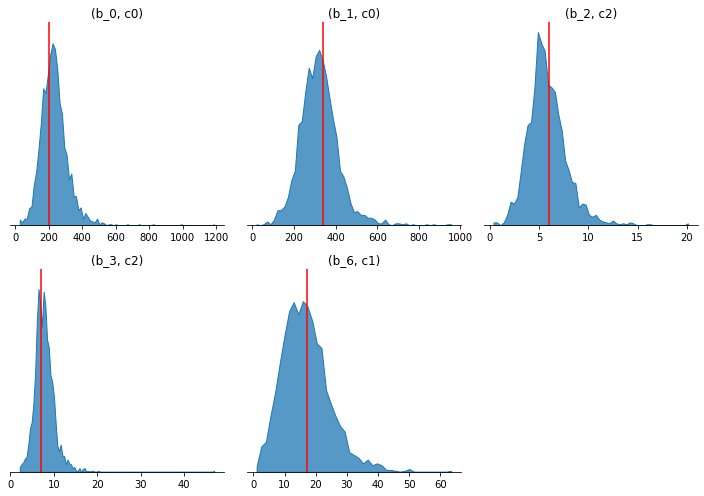

In [20]:
f, axes = plt.subplots(2, 3, figsize = (10, 7), sharey=True)
for ax, (row, col) in zip(axes.ravel(), index_to_null):
    trace_values = []
    for mat in samples:
        trace_values.append(mat.loc[row, col])
    sns.histplot(trace_values, ax=ax, element='poly', )
    ax.axvline(df.loc[row, col], color='r')
    ax.yaxis.set_visible(False)
    sns.despine(left=True, ax=ax)
    ax.set_title(f"({row}, {col})")
plt.tight_layout()
axes[1, 2].remove()